In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime

In [2]:

print("Loading dataset...")
data = pd.read_csv('/content/Mobile Phone Specifications and Prices(in).csv')

print("\nDataset info:")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")

print("\nMissing Values:")
print(data.isnull().sum())
print(f"Dataset contains null values: {data.isnull().values.any()}")

numerical_features = data.drop(['Price'], axis=1).select_dtypes(include='number').columns.tolist()
categorical_features = data.drop(['Price'], axis=1).select_dtypes(exclude='number').columns.tolist()

print("\nNumerical features:", numerical_features)
print("\nCategorical features:", categorical_features)


Loading dataset...

Dataset info:
Shape: (1359, 22)
Columns: ['Unnamed: 0', 'Name', 'Brand', 'Model', 'Battery capacity (mAh)', 'Screen size (inches)', 'Touchscreen', 'Resolution x', 'Resolution y', 'Processor', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera', 'Front camera', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', 'Number of SIMs', '3G', '4G/ LTE', 'Price']

Missing Values:
Unnamed: 0                0
Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                 

In [3]:

print("\nSplitting data into train and test sets...")
y = data['Price']
X = data.drop(['Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



Splitting data into train and test sets...
Training set shape: (1087, 21)
Test set shape: (272, 21)


In [4]:
estimators = [
    ('gbr', GradientBoostingRegressor(random_state=42,
                                        max_depth=2,
                                        learning_rate=0.01,
                                        min_samples_split=10,
                                        min_samples_leaf=5,
                                        subsample=0.8)),
    ('lr', LinearRegression())
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=42),
    cv=3,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('stack', stack)
])

param_dist = {
    'feature_selection__k': [5, 10, 'all'],
    'stack__gbr__n_estimators': [100, 150, 200],
    'stack__gbr__max_depth': [2, 3, 4],
    'stack__gbr__learning_rate': [0.01, 0.05, 0.1],
    'stack__gbr__min_samples_split': [10, 15],
    'stack__gbr__min_samples_leaf': [5, 10],
    'stack__final_estimator__alpha': [0.1, 1.0, 10.0]
}



Performing extended hyperparameter tuning with RandomizedSearchCV and StackingRegressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'stack__gbr__n_estimators': 100, 'stack__gbr__min_samples_split': 10, 'stack__gbr__min_samples_leaf': 5, 'stack__gbr__max_depth': 2, 'stack__gbr__learning_rate': 0.1, 'stack__final_estimator__alpha': 0.1, 'feature_selection__k': 'all'}

Performance Metrics:
Train MSE: 11140557.48
Test MSE: 65545147.61
Train RMSE: 3337.75
Test RMSE: 8096.00
Test R²: 0.75


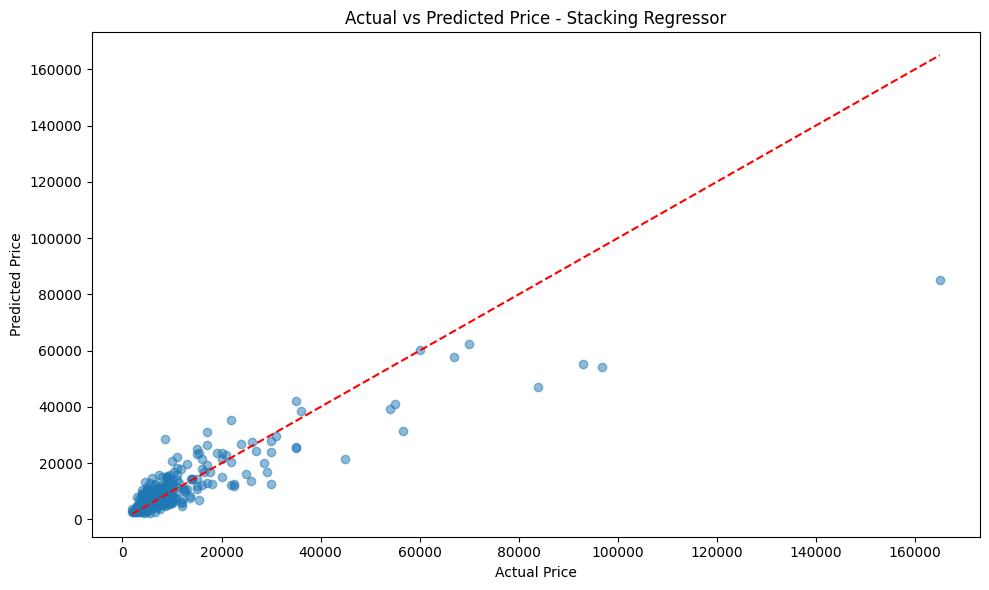

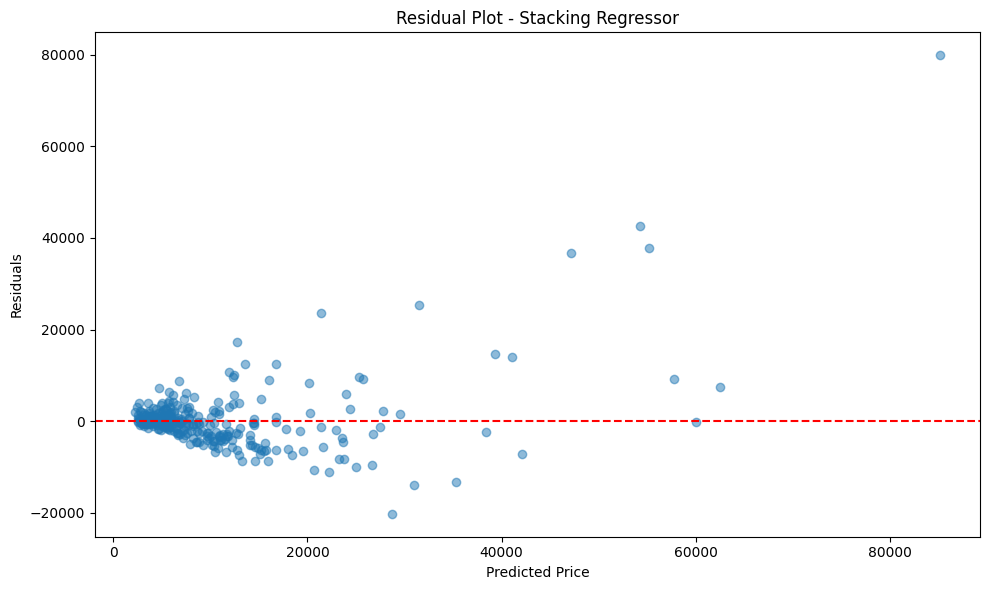


Results saved to stacking_results_20250323-061808.csv

Stacking Regressor model analysis complete with extended hyperparameter tuning, feature selection, and ensemble method!


In [5]:

print("\nPerforming extended hyperparameter tuning with RandomizedSearchCV and StackingRegressor...")
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

try:
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    print("\nBest Parameters:", random_search.best_params_)

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = sqrt(train_mse)
    test_rmse = sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nPerformance Metrics:")
    print(f"Train MSE: {train_mse:.2f}")
    print(f"Test MSE: {test_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.2f}")

    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Price - Stacking Regressor')
    plt.tight_layout()
    plt.show()

    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - Stacking Regressor')
    plt.tight_layout()
    plt.show()

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    results_file = f"stacking_results_{timestamp}.csv"
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_test_pred,
        'Residual': residuals
    })
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to {results_file}")

    print("\nStacking Regressor model analysis complete with extended hyperparameter tuning, feature selection, and ensemble method!")

except Exception as e:
    print(f"\nError during model training: {e}")
    print("\nDebugging information:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_train columns: {X_train.columns.tolist()}")
    print(f"X_train data types:\n{X_train.dtypes}")
